A notebook to explore availability of data for LinkBERT style pretraining.

## 0 Data, Libraires and Helper Functions

In [3]:
import pandas as pd
from semanticscholar import SemanticScholar
from tqdm.auto import tqdm
import networkx as nx
import time

import re


from crossref.restful import Works, CrossrefAPIError 



import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


def preprocess_doi(doi_string):
    """
    Clean and standardize a DOI (Digital Object Identifier) string.
    """
    if isinstance(doi_string, list):
        doi_string = doi_string[0] if doi_string else None
    if not isinstance(doi_string, str):
        return None
    doi_string = doi_string.lstrip('/')
    if 'doi.org/' in doi_string:
        doi_string = doi_string.split('doi.org/')[-1]
    return doi_string.strip()

def fix_title(title):
    """
    Normalizes a paper title string, using a simple rule to detect spaced-out text.
    Args:
        title (str or any): The input title to be cleaned.

    Returns:
        str: The normalized title string. Returns an empty string if input is not a string.
    """

    if not isinstance(title, str):
        return ""

    if "  " in title:
        placeholder = "@@@"
        
        title_fixed = re.sub(r'\s{2,}', placeholder, title)
        
        title_fixed = title_fixed.replace(' ', '')
        
        title = title_fixed.replace(placeholder, ' ')
        
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = " ".join(title.split())
    
    return title


def get_papers_s2_batch(sch, doi_chunk, fields):
    """
    Takes one shot at fetching a batch from Semantic Scholar.
    On any failure, it returns None, indicating the batch failed.
    """
    try:
        # A single attempt to fetch the batch.
        return sch.get_papers(doi_chunk, fields=fields)
    except Exception:
        # Catch TypeError, network errors, etc. If anything goes wrong,
        # signal failure by returning None.
        return None

def get_papers_robust(sch, doi_list, fields, failed_dois_list):
    if not doi_list: return []
    try:
        return sch.get_papers(doi_list, fields=fields)
    except TypeError:
        if len(doi_list) == 1:
            failed_dois_list.append((doi_list[0], 'TypeError'))
            return []
        tqdm.write(f"S2 Batch of {len(doi_list)} failed. Splitting...")
        mid = len(doi_list) // 2
        return get_papers_robust(sch, doi_list[:mid], fields, failed_dois_list) + \
               get_papers_robust(sch, doi_list[mid:], fields, failed_dois_list)
    except Exception as e:
        for doi in doi_list: failed_dois_list.append((doi, str(e)))
        return []

In [ ]:
df_full = pd.read_pickle("DATASET/ED4RE_2603.pickle")
df_full["backtrace_index"] = range(len(df_full))
df_full["DOI_processed"] = df_full["DOI"].apply(preprocess_doi)
df_full["Title_processed"] = df_full["Title"].apply(fix_title)

In [ ]:
df_full.drop(inplace=True, columns=['Title', 'Authors_and_Affiliations', 'Affiliations', 'DOI', 'Authors', 'Journal', 'Date', 'Subjects', 'Abstract', 'References', 'Content', 'Keywords', 'Style',])

## 1 DOI Matching

In [ ]:
df = df_full

In [ ]:
# 00:03:00 for 500 examples, 02:18:00 for 10000 examples
sch = SemanticScholar()
works = Works() 

# Create the master lookup map for node attributes
print("Creating master DOI-to-info map from the corpus...")
doi_to_info_map = {}
for index, row in tqdm(df.iterrows(), total=len(df), desc="Mapping DOIs"):
    clean_doi = row['DOI_processed']
    if clean_doi:
        doi_to_info_map[clean_doi] = {
            'index': row["backtrace_index"],
            'title': row['Title_processed']
        }

corpus_doi_set = set(doi_to_info_map.keys())
all_dois_to_query = list(corpus_doi_set)
print(f"Created a lookup map and a query list with {len(all_dois_to_query)} unique DOIs.")


fields_s2 = ['externalIds', 'citations.externalIds']
chunk_size = 50
doi_chunks = [all_dois_to_query[i:i + chunk_size] for i in range(0, len(all_dois_to_query), chunk_size)]
s2_papers = []
dois_for_crossref = []

print(f"\n--- Pass 1: Querying Semantic Scholar in {len(doi_chunks)} batches... ---")
for chunk in tqdm(doi_chunks, desc="S2 Fetching"):
    
    results = get_papers_s2_batch(sch, chunk, fields_s2)
    
    if results is None:
        # The entire batch failed. Delegate the whole chunk to Crossref.
        dois_for_crossref.extend(chunk)
    else:
        # The batch succeeded. Process the results.
        s2_papers.extend(results)
        
        # Still need to find which DOIs were "Not Found" by the API.
        found_dois = {p.externalIds['DOI'] for p in results if p and p.externalIds and 'DOI' in p.externalIds}
        not_found_dois = set(chunk) - found_dois
        dois_for_crossref.extend(list(not_found_dois))
        
    time.sleep(3)
    

# Process S2 results
s2_links = []
for paper in tqdm(s2_papers, desc="Building S2 Links"):
    if paper and paper.externalIds and (cited_doi := paper.externalIds.get('DOI')):
        if paper.citations:
            for citing_paper in paper.citations:
                if citing_paper and citing_paper.externalIds and (citing_doi := citing_paper.externalIds.get('DOI')):
                    if citing_doi in corpus_doi_set:
                        s2_links.append({'source_doi': citing_doi, 'target_doi': cited_doi})

print(f"Semantic Scholar Pass: Found {len(s2_links)} links. Failed on {len(dois_for_crossref)} DOIs.")

crossref_links = []

print(f"\n--- Pass 2: Querying Crossref for {len(dois_for_crossref)} failed DOIs... ---")
for source_doi in tqdm(dois_for_crossref, desc="Crossref Fallback"):
    try:
        work = works.doi(source_doi)
        if work and 'reference' in work:
            for ref in work['reference']:
                if 'DOI' in ref:
                    target_doi = preprocess_doi(ref['DOI'])
                    if target_doi in corpus_doi_set:
                        crossref_links.append({'source_doi': source_doi, 'target_doi': target_doi})
    except CrossrefAPIError as e:
        # Specifically handles 404 Not Found from Crossref
        pass 
    except Exception:
        # Catches other potential errors (network, etc.)
        pass
    time.sleep(0.1) # Be gentle with the Crossref API

print(f"Crossref Pass: Found {len(crossref_links)} additional links.")


print("\n--- Combining results and building final graph... ---")
# Create DataFrames and combine them
s2_links_df = pd.DataFrame(s2_links)
crossref_links_df = pd.DataFrame(crossref_links)
final_links_df = pd.concat([s2_links_df, crossref_links_df]).drop_duplicates().reset_index(drop=True)

print(f"Total unique links from all sources: {len(final_links_df)}")

# Explicitly build the graph to include attributes
G = nx.DiGraph()
for doi, info in doi_to_info_map.items():
    G.add_node(doi, index=info['index'], title=info['title'])

for _, row in final_links_df.iterrows():
    if G.has_node(row['source_doi']) and G.has_node(row['target_doi']):
        G.add_edge(row['source_doi'], row['target_doi'])

print(f"\nFinal graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Verify and save
nx.write_graphml(G, F"CG_N{len(G.nodes)}_E{len(G.edges)}.graphml")
print("Graph saved to hybrid_citation_graph.graphml")

In [ ]:
ID = 90506
print(df_full.iloc[ID]["Title"])
print(df_full.iloc[ID]["Title_processed"])
print(df_full.iloc[ID]["DOI_processed"])


## 2 Graph Analysis

Successfully loaded graph from 'CG_N167324_E395961.graphml'

--- 1. Basic Graph Statistics ---
Total number of nodes (papers in corpus): 167,324
Total number of edges (internal citations): 395,961

--- 2. Connected vs. Isolated Nodes ---
Number of nodes with degree > 0: 139,951
Number of isolated nodes (degree = 0): 27,373
Interpretation: These 139,951 nodes form the basis of your training data. The isolated nodes have no internal links.

--- 3. 'Connector' Node Statistics ---
Number of nodes with both in-degree > 0 AND out-degree > 0: 65,395
Interpretation: These 65,395 papers are true bridges in your corpus, linking different clusters of knowledge.

--- 4, 5, 6. Degree Distribution Analysis ---
Summary statistics for node degrees:
       in_degree  out_degree  total_degree
count  167324.00   167324.00     167324.00
mean        2.37        2.37          4.73
std        10.06        3.33         10.94
min         0.00        0.00          0.00
25%         0.00        0.00          1.00

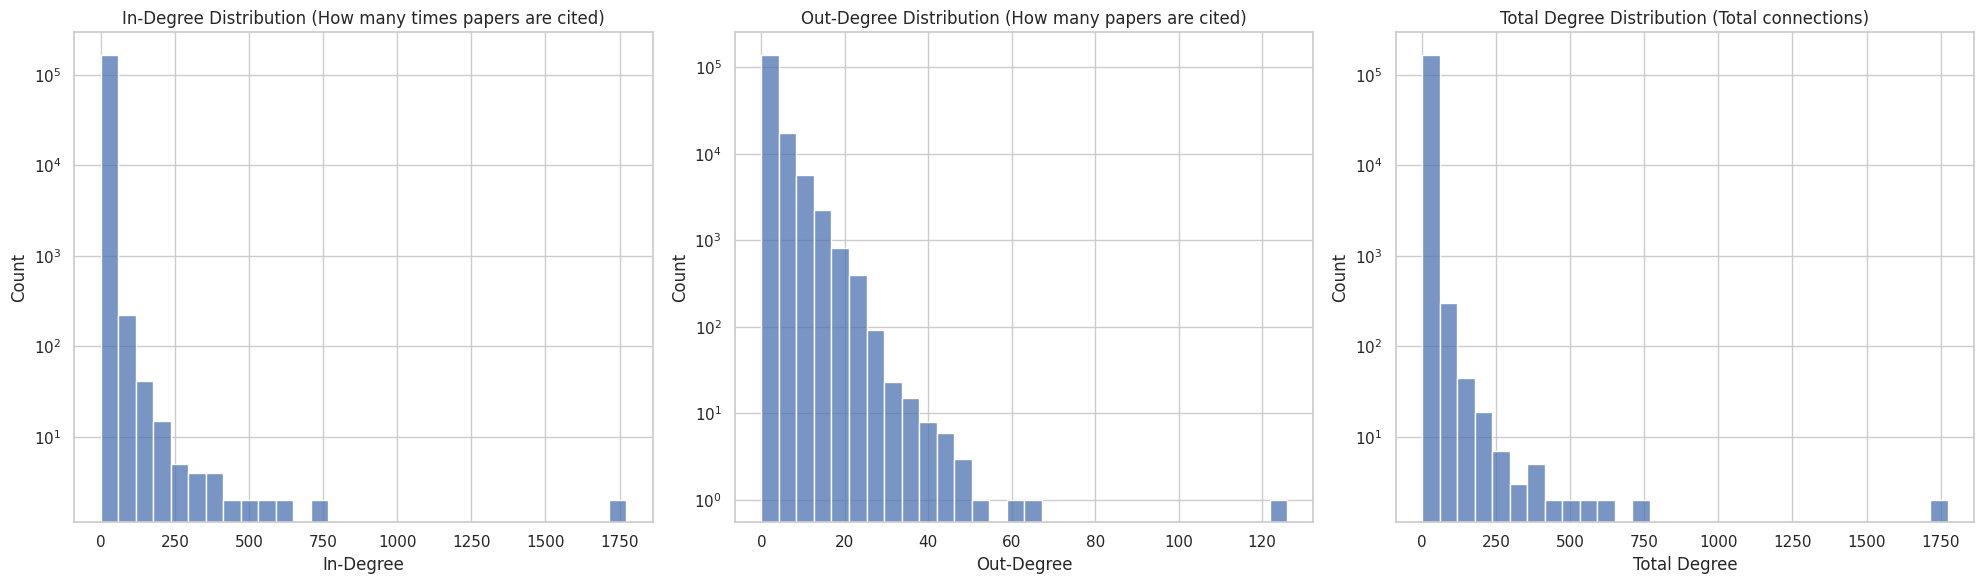

Interpretation: The 'long tail' in these distributions (viewed on a log scale) is typical of citation networks, indicating that a few papers are highly influential authorities.

--- 7. Advanced Statistics Relevant to LinkBERT ---
a) Component Analysis:
   Number of weakly connected components (islands of papers): 30,670
   Size of the largest component: 131,735 nodes (78.73%)
   Interpretation: A large main component is EXCELLENT for LinkBERT. It means the model can learn relationships across a huge portion of your dataset.

b) PageRank (Influence Score):
   Top 10 most influential papers by PageRank:
     - Score: 0.003865 | Title: storm track predictability on seasonal and decadal scales
     - Score: 0.002873 | Title: the influence of sea ice on ocean heat uptake in response to increasing cocorrigendum
     - Score: 0.001893 | Title: lowpressure systems and extreme precipitation in central india sensitivity to temperature changes
     - Score: 0.001438 | Title: intraseasonal respons

In [7]:
GRAPH_FILE_PATH = "CG_N167324_E395961.graphml"

try:
    G = nx.read_graphml(GRAPH_FILE_PATH)
    print(f"Successfully loaded graph from '{GRAPH_FILE_PATH}'")
except FileNotFoundError:
    print(f"Error: The file '{GRAPH_FILE_PATH}' was not found.")
    exit()

# --- Stat 1: Total Number of Nodes and Edges ---
print("\n--- 1. Basic Graph Statistics ---")
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Total number of nodes (papers in corpus): {num_nodes:,}")
print(f"Total number of edges (internal citations): {num_edges:,}")

# --- Stat 2: Number of "Connected" Nodes ---
# These are nodes that are not isolated in the graph.
isolates = list(nx.isolates(G))
num_connected_nodes = num_nodes - len(isolates)
print(f"\n--- 2. Connected vs. Isolated Nodes ---")
print(f"Number of nodes with degree > 0: {num_connected_nodes:,}")
print(f"Number of isolated nodes (degree = 0): {len(isolates):,}")
print(f"Interpretation: These {num_connected_nodes:,} nodes form the basis of your training data. The isolated nodes have no internal links.")

# --- Stat 3: Number of "Connector" Nodes ---
# These nodes both cite other papers in the corpus AND are cited by them.
# They are important hubs in the information flow.
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
connector_nodes = [
    node for node in G.nodes() 
    if in_degrees.get(node, 0) > 0 and out_degrees.get(node, 0) > 0
]
num_connector_nodes = len(connector_nodes)
print(f"\n--- 3. 'Connector' Node Statistics ---")
print(f"Number of nodes with both in-degree > 0 AND out-degree > 0: {num_connector_nodes:,}")
print(f"Interpretation: These {num_connector_nodes:,} papers are true bridges in your corpus, linking different clusters of knowledge.")

# --- Stats 4, 5, 6: Degree Distributions ---
# This is the most important part for understanding the graph's structure.
print("\n--- 4, 5, 6. Degree Distribution Analysis ---")
degree_df = pd.DataFrame({
    'in_degree': dict(G.in_degree()).values(),
    'out_degree': dict(G.out_degree()).values(),
    'total_degree': dict(G.degree()).values()
})

# Get summary statistics using pandas
print("Summary statistics for node degrees:")
print(degree_df.describe().round(2))

# Visualize the distributions
print("\nGenerating degree distribution plots...")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.set_theme(style="whitegrid")

# In-Degree Distribution
sns.histplot(degree_df['in_degree'], bins=30, ax=axes[0])
axes[0].set_title('In-Degree Distribution (How many times papers are cited)')
axes[0].set_yscale('log')
axes[0].set_xlabel('In-Degree')

# Out-Degree Distribution
sns.histplot(degree_df['out_degree'], bins=30, ax=axes[1])
axes[1].set_title('Out-Degree Distribution (How many papers are cited)')
axes[1].set_yscale('log')
axes[1].set_xlabel('Out-Degree')

# Total Degree Distribution
sns.histplot(degree_df['total_degree'], bins=30, ax=axes[2])
axes[2].set_title('Total Degree Distribution (Total connections)')
axes[2].set_yscale('log')
axes[2].set_xlabel('Total Degree')

plt.tight_layout()
plt.show()
print("Interpretation: The 'long tail' in these distributions (viewed on a log scale) is typical of citation networks, indicating that a few papers are highly influential authorities.")

# --- Stat 7: Other Interesting Stats for LinkBERT ---
print("\n--- 7. Advanced Statistics Relevant to LinkBERT ---")

# a) Component Analysis: Is the graph one big piece or many small islands?
num_weakly_components = nx.number_weakly_connected_components(G)
largest_wcc = max(nx.weakly_connected_components(G), key=len)
print(f"a) Component Analysis:")
print(f"   Number of weakly connected components (islands of papers): {num_weakly_components:,}")
print(f"   Size of the largest component: {len(largest_wcc):,} nodes ({(len(largest_wcc)/num_nodes):.2%})")
print(f"   Interpretation: A large main component is EXCELLENT for LinkBERT. It means the model can learn relationships across a huge portion of your dataset.")

# b) PageRank: Who are the most "influential" papers?
# PageRank is better than just in-degree because it weights citations from important papers more heavily.
print(f"\nb) PageRank (Influence Score):")
pagerank_scores = nx.pagerank(G, alpha=0.85)
# Sort nodes by PageRank score and get the top 10
top_10_pagerank = sorted(pagerank_scores.items(), key=lambda item: item[1], reverse=True)[:10]

print("   Top 10 most influential papers by PageRank:")
for doi, score in top_10_pagerank:
    title = G.nodes[doi].get('title', 'N/A')
    print(f"     - Score: {score:.6f} | Title: {title}")
print(f"   Interpretation: These are the 'authorities' in your corpus. Analyzing links to/from these nodes could provide high-quality training examples.")

# c) Reciprocity: How many papers cite each other?
reciprocity_score = nx.reciprocity(G)
print(f"\nc) Reciprocity (Mutual Citations):")
print(f"   Overall graph reciprocity: {reciprocity_score:.4f}")
print(f"   Interpretation: A non-zero reciprocity indicates the presence of 'A cites B' and 'B cites A' links. These 'dialogues' between papers can be very powerful training signals for a model.")

# Old

## 1 Initial analysis

In [ ]:

# --- Step 1: Calculate the number of references for each document ---
def get_reference_count(ref_entry):
    if isinstance(ref_entry, list):
        return len(ref_entry)
    elif ref_entry == "no_references":
        return 0
    else: # This handles strings and other non-list types
        return 1

# Apply this function to create a new column with the counts
df['num_references'] = df['References'].apply(get_reference_count)


# --- Step 2: Get high-level statistics ---

# First, let's count how many are neatly structured vs. single blobs
is_list_mask = df['References'].apply(lambda x: isinstance(x, list))
list_count = is_list_mask.sum()
string_blob_count = len(df) - list_count

print("="*60)
print("Analysis of Reference Column Structure")
print("="*60)
print(f"Total documents with potential references: {len(df):,}")
print(f"Documents with references as a list (good format): {list_count:,} ({list_count/len(df):.2%})")
print(f"Documents with references as a single string (needs parsing): {string_blob_count:,} ({string_blob_count/len(df):.2%})")
print("\n")


# # Now, let's get descriptive statistics on the 'num_references' column
# print("="*60)
# print("Descriptive Statistics for Number of References per Document")
# print("="*60)
# # The describe() output will be heavily influenced by the single-string blobs (value=1)
# # so we'll show stats for both all data and just the list-formatted data.
# print("--- Overall (including single-string blobs as 1) ---")
# print(df['num_references'].describe())
# print("\n")

# Filter for only the documents that had a list to get a cleaner distribution
df_lists_only = df[is_list_mask]
print("--- For List-Formatted References Only ---")
print(df_lists_only['num_references'].describe())
print("="*60)


**Observation 1**:

Total documents with potential references: 171,880
Documents with references as a list (good format): 162,726 (94.67%)
Documents with references as a single string (needs parsing): 9,154 (5.33%)

count    162726
mean         52.317902
std         583.275877
min           0
25%          33
50%          45
75%          60
max      169759

75% of references are lists that contain up to 60 references, this seems like a reasonable maximum number? Let's look at a random sample to feel the data.

In [ ]:
a = df_lists_only[df_lists_only.num_references <= 10].sample(100)["Title"].to_list()

def fix_title(title):
    """
    Normalizes a paper title string, using a simple rule to detect spaced-out text.

    The logic is:
    1. Check if the title contains a double-space ("  ").
    2. IF IT DOES: Assume it's "spaced-out" text (e.g., "T i t l e   W o r d").
       - Mark the real word breaks (the double-spaces) with a placeholder.
       - Remove all single spaces (the junk between letters).
       - Restore the real word breaks.
    3. IF IT DOES NOT: Treat it as a normal title.
    4. Finally, apply standard cleaning (lowercase, remove punctuation, etc.) to all titles.

    Args:
        title (str or any): The input title to be cleaned.

    Returns:
        str: The normalized title string. Returns an empty string if input is not a string.
    """

    if not isinstance(title, str):
        return ""

    if "  " in title:
        placeholder = "@@@"
        
        title_fixed = re.sub(r'\s{2,}', placeholder, title)
        
        title_fixed = title_fixed.replace(' ', '')
        
        title = title_fixed.replace(placeholder, ' ')
        
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = " ".join(title.split())
    
    return title

for title in a:
    print(title)
    print(fix_title(title))
    print()


This function seems to be working for titles, next, reference titles should be tackled.

In [ ]:
def extract_title_from_reference(ref_string):
    """
    Extracts the most likely title from a scientific reference string.

    This uses a simple but robust heuristic:
    1. Removes bracketed metadata (e.g., [CrossRef]).
    2. Splits the reference by periods ('.').
    3. Assumes the longest resulting segment is the title.

    Args:
        ref_string (str): The reference string to parse.

    Returns:
        str: The extracted title, or None if no suitable title is found.
    """
    if not isinstance(ref_string, str):
        return None

    # 1. Pre-clean: Remove bracketed metadata like [Google Scholar] [CrossRef]
    cleaned_ref = re.sub(r'\[.*?\]', '', ref_string).strip()
    
    # 2. Split the string into major parts using the period as a delimiter
    parts = cleaned_ref.split('.')
    
    # 3. Filter out empty or very short parts that can't be titles
    # A title usually has some substance. We also strip whitespace from each part.
    potential_titles = [part.strip() for part in parts if len(part.strip()) > 10]
    
    # If, after filtering, there are no candidates, we can't find a title
    if not potential_titles:
        return None
        
    # 4. Select the longest part from the candidates
    # The title is almost always the longest meaningful segment of a reference.
    title = max(potential_titles, key=len)
    
    return title


In [ ]:
for ref in df_lists_only[df_lists_only.num_references <= 100].sample(1)["References"].to_list()[0]:
    print(ref)
    print(extract_title_from_reference(ref))
    print(fix_title(extract_title_from_reference(ref)))
    print()


This setup seems to work good for references.

In [ ]:
def extract_year(date_string):
    """
    Extracts the most likely publication year from a messy date string.

    This function tries several strategies in order:
    1. Looks for a year in a "Published: ..." line.
    2. If not found, it searches for any four-digit number starting with 19 or 20.
    3. Returns the last year found in the string, as 'Published' is usually last.

    Args:
        date_string (str): The messy string from the 'Date' column.

    Returns:
        int or None: The extracted four-digit year as an integer, or None if no
                     plausible year can be found.
    """
    if not isinstance(date_string, str):
        return None

    published_match = re.search(r'Published: .*?(\b(19|20)\d{2}\b)', date_string)
    if published_match:
        return int(published_match.group(1))

    all_years = re.findall(r'\b(?:19|20)\d{2}\b', date_string)
    
    if all_years:
        return int(all_years[-1])

    # If no year could be found, return None
    return "no_date"

for date in df_lists_only.Date.sample(100).tolist():
    print(date)
    print(extract_year(date))
    print()

## 2 Implementation

In [ ]:
import pandas as pd
import re
from rapidfuzz import fuzz, process
from tqdm.auto import tqdm # For a nice progress bar!


def fix_title(title):
    """
    Normalizes a paper title string, using a simple rule to detect spaced-out text.
    Args:
        title (str or any): The input title to be cleaned.

    Returns:
        str: The normalized title string. Returns an empty string if input is not a string.
    """

    if not isinstance(title, str):
        return ""

    if "  " in title:
        placeholder = "@@@"
        
        title_fixed = re.sub(r'\s{2,}', placeholder, title)
        
        title_fixed = title_fixed.replace(' ', '')
        
        title = title_fixed.replace(placeholder, ' ')
        
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = " ".join(title.split())
    
    return title

def extract_title_from_reference(ref_string):
    """
    Extracts the most likely title from a scientific reference string.
    Args:
        ref_string (str): The reference string to parse.

    Returns:
        str: The extracted title, or None if no suitable title is found.
    """
    if not isinstance(ref_string, str):
        return None

    # 1. Pre-clean: Remove bracketed metadata like [Google Scholar] [CrossRef]
    cleaned_ref = re.sub(r'\[.*?\]', '', ref_string).strip()
    
    # 2. Split the string into major parts using the period as a delimiter
    parts = cleaned_ref.split('.')
    
    # 3. Filter out empty or very short parts that can't be titles
    # A title usually has some substance. We also strip whitespace from each part.
    potential_titles = [part.strip() for part in parts if len(part.strip()) > 10]
    
    # If, after filtering, there are no candidates, we can't find a title
    if not potential_titles:
        return None
        
    # 4. Select the longest part from the candidates
    # The title is almost always the longest meaningful segment of a reference.
    title = max(potential_titles, key=len)
    
    return title

def extract_year(date_string):
    """
    Extracts the most likely publication year from a messy date string.
    Args:
        date_string (str): The messy string from the 'Date' column.

    Returns:
        int or None: The extracted four-digit year as an integer, or None if no
                     plausible year can be found.
    """
    if not isinstance(date_string, str):
        return None

    published_match = re.search(r'Published: .*?(\b(19|20)\d{2}\b)', date_string)
    if published_match:
        return int(published_match.group(1))

    all_years = re.findall(r'\b(?:19|20)\d{2}\b', date_string)
    
    if all_years:
        return int(all_years[-1])

    # If no year could be found, return None
    return "no_date"

def find_best_match_for_reference_v2(ref_title, corpus_df, titles_map, ref_year=None, threshold=85, year_tol=5):
    if not ref_title: return None, None, None
    if ref_title in titles_map: return ref_title, titles_map[ref_title], 100
    
    candidate_corpus = corpus_df
    if ref_year is not None and 'year' in corpus_df.columns and pd.api.types.is_numeric_dtype(corpus_df['year']):
        filtered_view = corpus_df[corpus_df['year'].between(ref_year - year_tol, ref_year + year_tol)]
        if not filtered_view.empty: candidate_corpus = filtered_view
            
    candidate_titles = list(candidate_corpus['normalized_title'])
    candidate_indices = list(candidate_corpus.index)
    if not candidate_titles: return None, None, None

    best_match = process.extractOne(ref_title, candidate_titles, scorer=fuzz.WRatio, score_cutoff=threshold)

    if best_match:
        matched_title_str, score, original_list_index = best_match
        corpus_idx = candidate_indices[original_list_index]
        return matched_title_str, corpus_idx, score
    
    return None, None, None


df = df_lists_only[df_lists_only.num_references <= 100] # Use your actual DataFrame here

print("Preparing the corpus...")
# Use tqdm to see progress on large dataframes
tqdm.pandas(desc="Normalizing Titles")
df['normalized_title'] = df['Title'].progress_apply(fix_title)

tqdm.pandas(desc="Extracting Years")
df['year'] = df['Date'].progress_apply(extract_year)

# Create the fast lookup map for exact matches
print("Creating title-to-index map...")
corpus_titles_map = {title: idx for idx, title in df['normalized_title'].items() if title}


# --- Step 3: The Main Linking Loop ---

print("\nStarting the reference linking process...")
citation_links = []
# We iterate through each row of the DataFrame
for source_index, row in tqdm(df.iterrows(), total=len(df), desc="Linking Documents"):
    references = row['References']
    source_title = row['Title']
    
    # Ensure references is a list of strings
    if not isinstance(references, list):
        continue

    for ref_string in references:
        # Extract and normalize title from the reference string
        raw_ref_title = extract_title_from_reference(ref_string)
        norm_ref_title = fix_title(raw_ref_title)
        
        # Extract year from the reference string
        ref_year = extract_year(ref_string)

        # Find the best match in the entire corpus
        matched_title, target_index, score = find_best_match_for_reference_v2(
            norm_ref_title,
            df,
            corpus_titles_map,
            ref_year=ref_year,
            threshold=85, # You can tune this!
            year_tol=2
        )

        # If a good match was found, store it
        if target_index is not None:
            citation_links.append({
                'source_index': source_index,
                'source_title': source_title,
                'reference_string': ref_string,
                'target_index': target_index,
                'matched_corpus_title': df.loc[target_index, 'Title'],
                'match_score': score
            })

# --- Step 4: Create and Analyze the Results DataFrame ---

print(f"\nProcess complete. Found {len(citation_links)} potential links.")

# Create a new DataFrame from the results
links_df = pd.DataFrame(citation_links)

print("\nSample of created links:")
print(links_df.head().to_string())

# Analyze the distribution of match scores
if not links_df.empty:
    print("\nDistribution of match scores:")
    print(links_df['match_score'].describe())
    
    # It's also very useful to look at the borderline cases
    print("\nExamples of borderline matches (score between 85 and 90):")
    borderline_cases = links_df[(links_df['match_score'] > 85) & (links_df['match_score'] < 90)]
    print(borderline_cases.head(5).to_string())

## 3 Tryout

In [ ]:
def fix_title(title):
    """
    Normalizes a paper title string, using a simple rule to detect spaced-out text.
    Args:
        title (str or any): The input title to be cleaned.

    Returns:
        str: The normalized title string. Returns an empty string if input is not a string.
    """

    if not isinstance(title, str):
        return ""

    if "  " in title:
        placeholder = "@@@"
        
        title_fixed = re.sub(r'\s{2,}', placeholder, title)
        
        title_fixed = title_fixed.replace(' ', '')
        
        title = title_fixed.replace(placeholder, ' ')
        
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = " ".join(title.split())
    
    return title

def extract_year(date_string):
    """
    Extracts the most likely publication year from a messy date string.
    Args:
        date_string (str): The messy string from the 'Date' column.

    Returns:
        int or None: The extracted four-digit year as an integer, or None if no
                     plausible year can be found.
    """
    if not isinstance(date_string, str):
        return None

    published_match = re.search(r'Published: .*?(\b(19|20)\d{2}\b)', date_string)
    if published_match:
        return int(published_match.group(1))

    all_years = re.findall(r'\b(?:19|20)\d{2}\b', date_string)
    
    if all_years:
        return int(all_years[-1])

    # If no year could be found, return None
    return "no_date"


In [ ]:
links = pd.read_pickle("citation_links_199142.pickle")

In [ ]:

df = pd.read_pickle("DATASET/ED4RE_2503/ED4RE_2603.pickle")
is_list_mask = df['References'].apply(lambda x: isinstance(x, list))
df_lists_only = df[is_list_mask]
df = df_lists_only.copy()

In [ ]:

import networkx as nx
from tqdm.auto import tqdm

tqdm.pandas(desc="Normalizing Titles")
df['normalized_title'] = df['Title'].progress_apply(fix_title)

tqdm.pandas(desc="Extracting Years")
df['year'] = df['Date'].progress_apply(extract_year)


# Let's use the high-confidence links for a cleaner graph
CONFIDENCE_THRESHOLD = 90
if 'match_score' in links.columns:
    graph_df = links[links['match_score'] >= CONFIDENCE_THRESHOLD].copy()
else:
    graph_df = links.copy()

print(f"Building graph from {len(graph_df)} high-confidence links.")

# 1. Identify all unique nodes from your links
# These are all the paper indices that are either a source or a target.
all_node_indices = pd.concat([
    graph_df['source_index'], 
    graph_df['target_index']
]).unique()

print(f"Found {len(all_node_indices)} unique papers (nodes) in the network.")

# 2. Get the attributes for these nodes (the titles) from the main DataFrame
# We select only the rows from the main 'df' that correspond to our nodes.
node_attributes_df = df.loc[all_node_indices, ['normalized_title', 'year']]

# 3. Create the list of nodes in the format networkx expects:
# [(node_id, {attribute_dict}), (node_id_2, {attribute_dict_2}), ...]
nodes_with_attrs = [
    (index, {"title": row["normalized_title"], "year": row["year"]}) 
    for index, row in node_attributes_df.iterrows()
]

# 4. Create the list of edges from your links DataFrame
# This is a simple list of (source, target) tuples.
edges = list(graph_df[['source_index', 'target_index']].to_records(index=False))

# 1. Create a new directed graph
G = nx.DiGraph()

# 2. Add the nodes and edges
G.add_nodes_from(nodes_with_attrs)
G.add_edges_from(edges)

print("\nGraph created successfully!")
print("--- Basic Graph Statistics ---")
print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")

# The density of a graph is the ratio of actual edges to all possible edges.
# Citation networks are extremely sparse, so this number will be tiny.
density = nx.density(G)
print(f"Graph density: {density:.6f}")

# --- Find the most influential papers (most cited) ---
# In a citation network, this means finding the nodes with the highest "in-degree".
in_degrees = G.in_degree() # This returns a list of (node, degree) tuples
top_10_cited = sorted(in_degrees, key=lambda x: x[1], reverse=True)[:10]

print("\n--- Top 10 Most Cited Papers in Your Corpus ---")
for node_id, degree in top_10_cited:
    # Use the node attribute 'title' that we added earlier
    title = G.nodes[node_id]['title']
    print(f"Citations: {degree:<5} | Title: {title}")

In [ ]:
nx.write_graphml(G, f"citation_graph_{len(G.nodes)}.graphml")

Overall, this fuzzy matching between titles and references is not working good, and is slow, doi with API request should be tackled.